In [1]:
#initialization
import itertools as it
from scipy.sparse import csr_matrix
import scipy
import matplotlib.pyplot as plt
import numpy as np
pi = np.pi
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
import qiskit.extensions
# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
def vec_to_state(vec):
    n_vertices = int(np.log2(len(vec)))
    basis_list = list(it.product(range(2), repeat=n_vertices))
    indices = np.nonzero(vec)[0]
    return {basis_list[i]:vec[i] for i in indices}

def state_to_vec(state):
    ''' state is a list of state '''
    n_vertices = len(state[0])
    basis_list = list(it.product(range(2), repeat=n_vertices))
    basis_dict = {basis_list[i]: i for i in range(2**n_vertices)}
    vec = np.zeros(2**n_vertices)
    for s in state:
        vec[basis_dict[s]] = 1
    return vec

def boundary_operator(x_tuple):
    x_np = np.array(x_tuple)
    indices = np.nonzero(x_np)[0]
    dictionary = {}
    k = len(indices)
    for i in range(k):
        helper = x_np.copy()
        helper[indices[k-1-i]] = 0
        dictionary[tuple(helper)] = (-1)**(i)
    return dictionary

def boundary_operator_dict(n_vertices):
    dictionary = {}
    dictionary[(tuple([0 for i in range(n_vertices)]),tuple([0 for i in range(n_vertices)]))] = 0
    for b in it.product(range(2), repeat=n_vertices):
        helper = boundary_operator(b)
        for key in helper.keys():
            dictionary[(tuple(b),key)] = helper[key]
    return dictionary

def boundary_operator_dict_k(n_vertices, k):
    dictionary = {}
    dictionary[(tuple([0 for i in range(n_vertices)]),tuple([0 for i in range(n_vertices)]))] = 0
    for b in it.product(range(2), repeat=n_vertices):
        if np.sum(b) == k:
            helper = boundary_operator(b)
            for key in helper.keys():
                dictionary[(tuple(b),key)] = helper[key]
    return dictionary

def boundary_operator_crsmat(n_vertices):
    dictionary = boundary_operator_dict(n_vertices)
    basis_list = list(it.product(range(2), repeat=n_vertices))
    basis_dict = {basis_list[i]: i for i in range(2**n_vertices)}
    col = np.array([basis_dict[index[0]] for index in dictionary.keys()])
    row = np.array([basis_dict[index[1]] for index in dictionary.keys()])
    data = np.array(list(dictionary.values()))
    return csr_matrix((data, (row, col)), shape=(2**n_vertices, 2**n_vertices))

def boundary_operator_crsmat_k(n_vertices, k):
    dictionary = boundary_operator_dict_k(n_vertices, k)
    basis_list = list(it.product(range(2), repeat=n_vertices))
    basis_dict = {basis_list[i]: i for i in range(2**n_vertices)}
    col = np.array([basis_dict[index[0]] for index in dictionary.keys()])
    row = np.array([basis_dict[index[1]] for index in dictionary.keys()])
    data = np.array(list(dictionary.values()))
    return csr_matrix((data, (row, col)), shape=(2**n_vertices, 2**n_vertices))

In [3]:
mat = boundary_operator_crsmat(4).toarray()

In [4]:
state = [(1,1,0,1,0,0,1)]
n_vertices = len(state[0])
mat = boundary_operator_crsmat(n_vertices).toarray()
vec = state_to_vec(state)
vec_to_state(mat@vec)

{(0, 1, 0, 1, 0, 0, 1): -1.0,
 (1, 0, 0, 1, 0, 0, 1): 1.0,
 (1, 1, 0, 0, 0, 0, 1): -1.0,
 (1, 1, 0, 1, 0, 0, 0): 1.0}

In [5]:
k = 2
n_vertices=4

delta_k = boundary_operator_crsmat_k(n_vertices, k).toarray()
delta_kplus1 = boundary_operator_crsmat_k(n_vertices, k+1).toarray()
combinatorial_laplacian = delta_k.conj().T @ delta_k + delta_kplus1 @ delta_kplus1.conj().T

In [8]:
test_mode = False

k = 2
n_vertices=3

delta_k = boundary_operator_crsmat_k(n_vertices, k).toarray()
delta_kplus1 = boundary_operator_crsmat_k(n_vertices, k+1).toarray()
combinatorial_laplacian = delta_k.conj().T @ delta_k + delta_kplus1 @ delta_kplus1.conj().T

if(test_mode):
    combinatorial_laplacian = (np.pi/2)*np.diag((1,1,1,1,1,1,1,1))
    combinatorial_laplacian 


unit = scipy.linalg.expm(1j*combinatorial_laplacian)

import qiskit.extensions
gate = qiskit.extensions.UnitaryGate(unit)

In [9]:
def init(num_qubits,a,b):
    for qubit in range(num_qubits):
        qpe.h(qubit)
    qpe.x(a)
    qpe.x(b)
    return qpe
#qpe = init(num_qubits,5, 6)
#qpe.draw()

In [10]:
def controledU(rep, num_qubits):
    repetitions = rep
    for counting_qubit in range(num_qubits):
        for i in range(repetitions):
            qpe.append(gate.control(1),(counting_qubit,num_qubits,num_qubits+1,num_qubits+2))
        repetitions *= 2
    return qpe
#controledU(1, num_qubits)
#qpe.draw()

In [11]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

In [12]:
def qpe_total(num_qubits, dim_unitary):
    init(num_qubits,5, 6)
    controledU(1, num_qubits)
    qpe.barrier()
    # Apply inverse QFT
    qft_dagger(qpe, num_qubits)
    # Measure
    qpe.barrier()
    for n in range(num_qubits):
        qpe.measure(n,n)
    return qpe

In [13]:
num_qubits = 5
dim_unitary = 3
qpe = QuantumCircuit(num_qubits + dim_unitary, num_qubits)

qpe_total(num_qubits, dim_unitary)

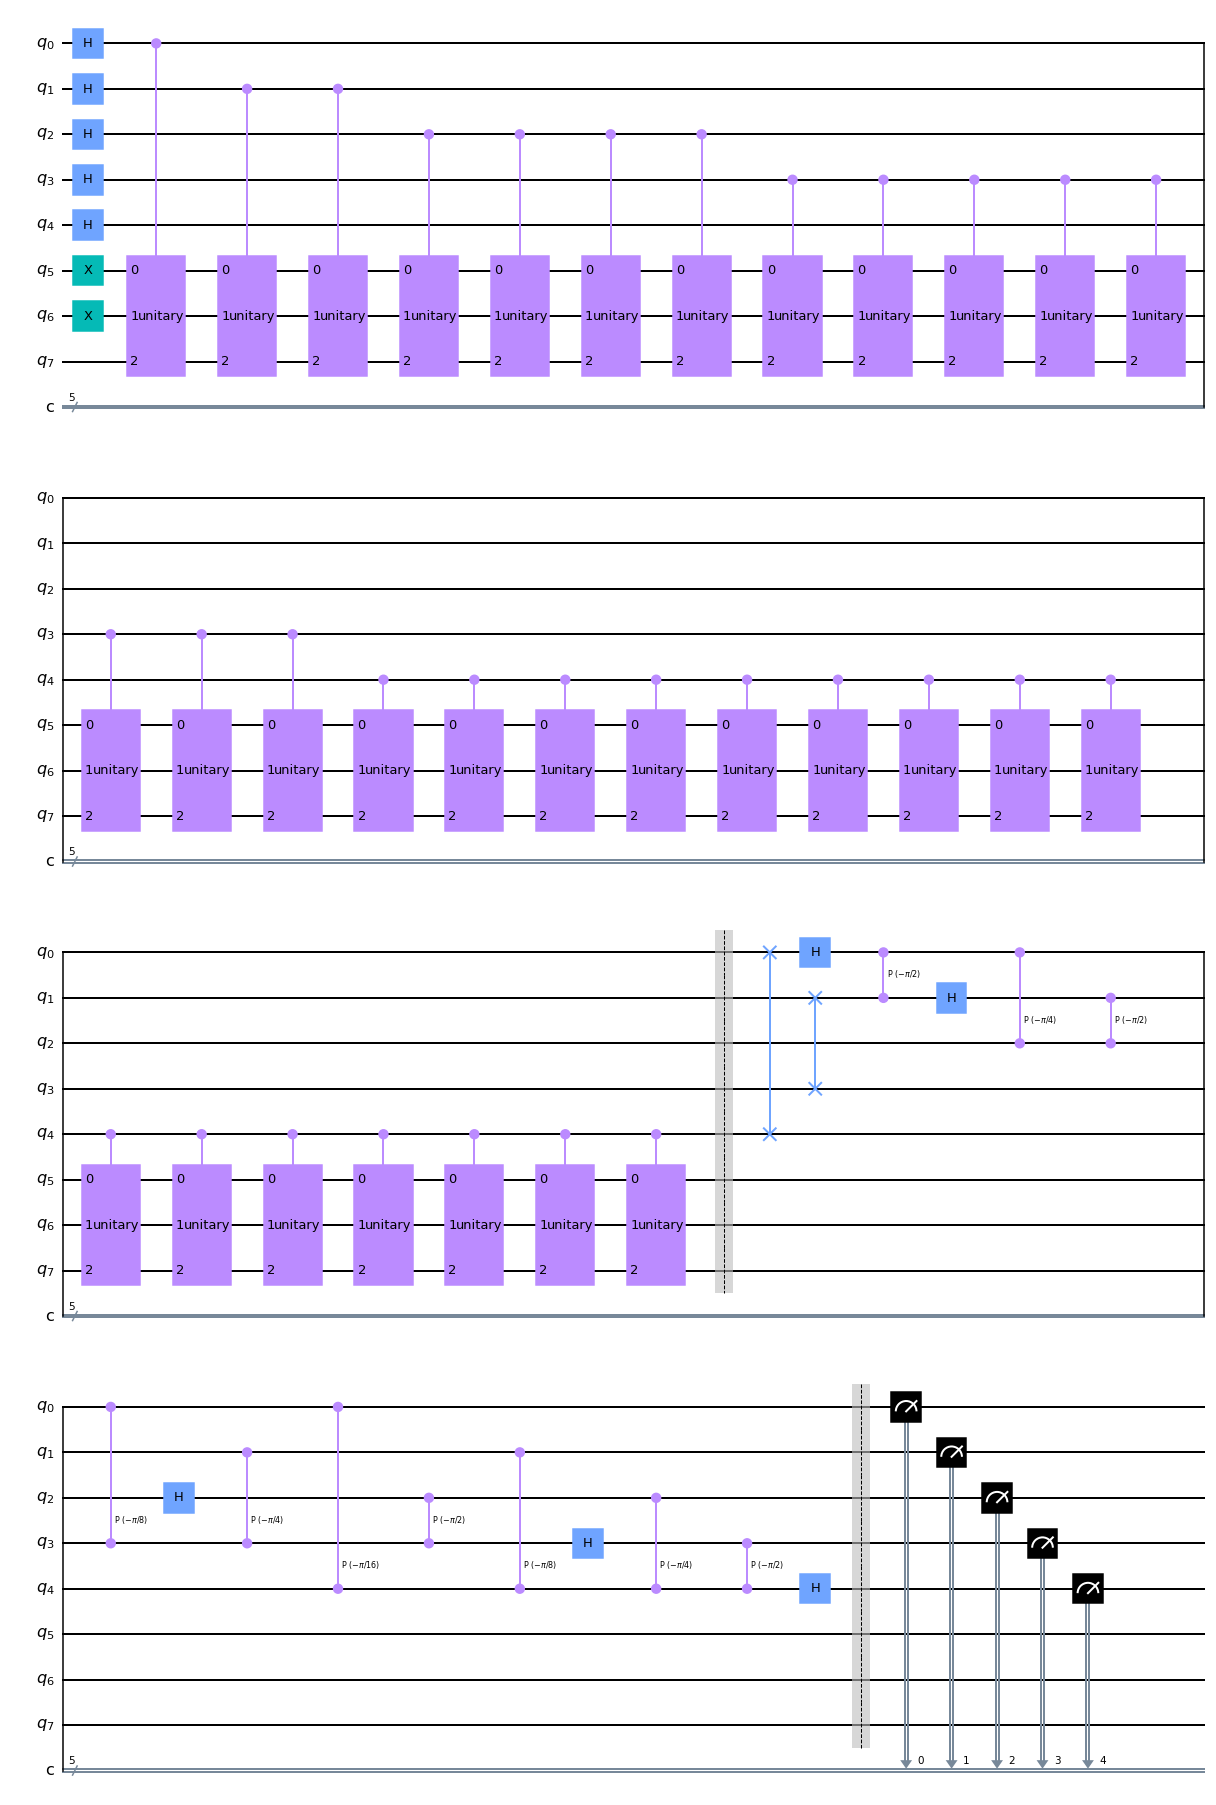

In [14]:
qpe.draw()

In [15]:
def run_qpe():
    qasm_sim = Aer.get_backend('qasm_simulator')
    shots = 2048
    t_qpe = transpile(qpe, qasm_sim)
    qobj = assemble(t_qpe, shots=shots)
    results = qasm_sim.run(qobj).result()
    answer = results.get_counts()
    return answer

{'11100': 1, '11110': 1, '00100': 2, '00011': 2, '00111': 3, '10100': 4, '11101': 1, '10111': 3, '01001': 4, '00001': 2, '01101': 22, '10011': 14, '00110': 3, '01010': 6, '10001': 36, '01110': 72, '01111': 1579, '00010': 1, '10110': 2, '10010': 11, '01000': 3, '11011': 2, '01100': 12, '00000': 1, '01011': 7, '11001': 3, '10000': 246, '10101': 5}


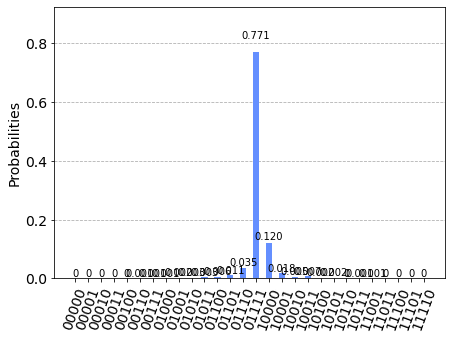

In [17]:
answer = run_qpe()
print(answer)
plot_histogram(answer)